# Intro

A great course on Large Language Models (LLMs) will be [here](https://github.com/karpathy/LLM101n?tab=readme-ov-file) from Andrej Karapathy, currently under developement.

The filed of Natural Language Processing (NLP) has a lot more to offer than just "Language Models" that generate text, but to keep it simple we will focus on that part.

## A full Language Model example
We will use a "Small Language Model" as we can run it easily on our CPU or in Colab to do some fun first experiments.  Not sure if there even as a threshold when to consider a model "large", but for now let's call models above like 7 billion parameter "Large Language Models"
Model Source: https://huggingface.co/HuggingFaceTB/SmolLM-135M-Instruct

In [1]:
# %pip install transformers
# %pip install scikit-learn
# %pip install matplotlib
# %pip install seaborn

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from torch import no_grad, argmax
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import random
import numpy as np
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
checkpoint = "HuggingFaceTB/SmolLM-135M-Instruct"

device = "cpu" # for GPU usage "cuda" or for CPU usage "cpu"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(49152, 576, padding_idx=2)
    (layers): ModuleList(
      (0-29): 30 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=576, out_features=576, bias=False)
          (k_proj): Linear(in_features=576, out_features=192, bias=False)
          (v_proj): Linear(in_features=576, out_features=192, bias=False)
          (o_proj): Linear(in_features=576, out_features=576, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=576, out_features=1536, bias=False)
          (up_proj): Linear(in_features=576, out_features=1536, bias=False)
          (down_proj): Linear(in_features=1536, out_features=576, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((576,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((576,), eps=1e-05)
      )
    )
    (norm

In [4]:
messages = [{"role": "user", "content": "What is the capital of France."}]
input_text=tokenizer.apply_chat_template(messages, tokenize=False)
print(input_text)
inputs = tokenizer.encode(input_text, return_tensors="pt").to(device)
outputs = model.generate(inputs, max_new_tokens=50, temperature=0.2, top_p=0.9, do_sample=True)
print(tokenizer.decode(outputs[0]))

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


<|im_start|>user
What is the capital of France.<|im_end|>

<|im_start|>user
What is the capital of France.<|im_end|>
<|im_start|>assistant
What a great question!

The capital of France is Paris, which is the largest city in France and the financial capital of the country. While there are many other cities in France, Paris is the most populous and is the


## Breaking it down step by step

### Tokenization

is the process of splitting a piece of text into smaller units, called tokens. These tokens can be words, characters, or subwords, depending on the level of granularity you want. In the context of NLP, tokens are typically words or meaningful units of text. For Language Models words or subwords are often used. For a model to be able to use these tokens they need to be mapped to a number.

The simplest tokenizer would be a lookup table for characters. In a "useful" LM tokenizers are a bit more complex and usually use subwords.

In [5]:
dict(list(tokenizer.vocab.items())[:5])

{'world': 6693,
 'daily': 33521,
 'Ġhashlib': 46355,
 'Ġoversaw': 47386,
 'Ġresumes': 48784}

In [6]:
len(tokenizer.vocab)

49152

In [7]:
tokenizer.vocab["Hello"]

19556

In [8]:
try: tokenizer.vocab["Hell"]
except Exception as e: print(type(e),str(e))

print(tokenizer.encode("Hell"))
print(tokenizer.vocab["H"])
print(tokenizer.vocab["ell"])

<class 'KeyError'> 'Hell'
[56, 478]
56
478


In [9]:
print(tokenizer.encode("Hello"))
print(tokenizer.encode("Hello,"))
print(tokenizer.encode("Hello, World"))
print(tokenizer.encode("Hello, World!"))

[19556]
[19556, 28]
[19556, 28, 2260]
[19556, 28, 2260, 17]


In [10]:
tokenizer.special_tokens_map

{'bos_token': '<|im_start|>',
 'eos_token': '<|im_end|>',
 'unk_token': '<|endoftext|>',
 'pad_token': '<|im_end|>',
 'additional_special_tokens': ['<|im_start|>', '<|im_end|>']}

In [11]:
print(tokenizer.vocab["<|im_start|>"])
print(tokenizer.vocab["<|im_end|>"])

1
2


In [12]:
messages = [{"role": "user", "content": "What is the capital of France."}]
print(tokenizer.apply_chat_template(messages, tokenize=False))

<|im_start|>user
What is the capital of France.<|im_end|>



In [13]:
messages = [{"role": "user", "content": "What is the capital of France."}, {"role": "assistant", "content": "It is Paris."}]
print(tokenizer.apply_chat_template(messages, tokenize=False))
print(tokenizer.apply_chat_template(messages))

<|im_start|>user
What is the capital of France.<|im_end|>
<|im_start|>assistant
It is Paris.<|im_end|>

[1, 4093, 198, 1780, 314, 260, 3575, 282, 4649, 30, 2, 198, 1, 520, 9531, 198, 1589, 314, 7042, 30, 2, 198]


### Embeddings
TODO: short explanation  
Explain why 576 dimensions and potentially interpret their "meaning". We use PCA to visualize.

In [14]:
input_ids = tokenizer.encode("Hello, World!", return_tensors="pt")
input_ids

tensor([[19556,    28,  2260,    17]])

In [15]:
# Extract the embedding layer from the model
embedding_layer = model.model.embed_tokens
# Get the output after the embedding layer
with no_grad():
    embeddings_output = embedding_layer(input_ids)
print(embeddings_output.shape)
embeddings_output

torch.Size([1, 4, 576])


tensor([[[ 0.0034,  0.4121,  0.0613,  ...,  0.2812,  0.0894,  0.0198],
         [-0.0796,  0.0957, -0.2559,  ..., -0.1436,  0.1201,  0.0674],
         [ 0.2910,  0.0737,  0.0571,  ...,  0.0481, -0.0542,  0.1719],
         [-0.1699, -0.1816, -0.0713,  ..., -0.3086, -0.0913,  0.1030]]])

torch.Size([5, 1, 576])
(5, 576)


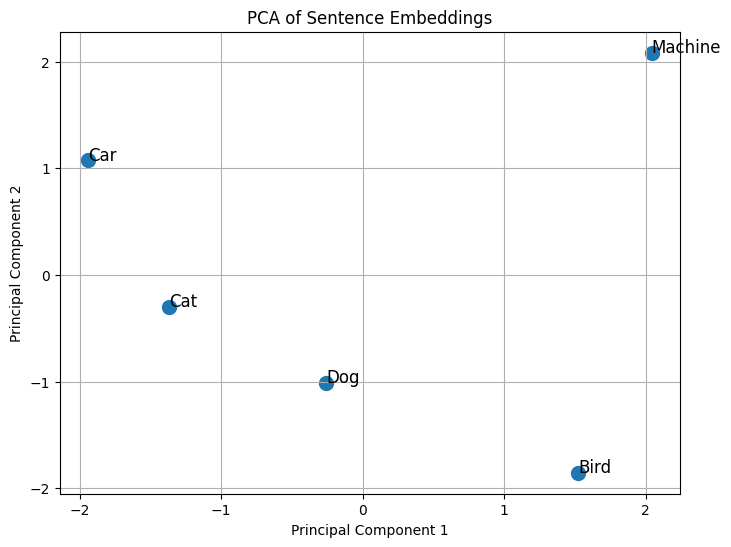

torch.Size([5, 8, 576])
(5, 576)


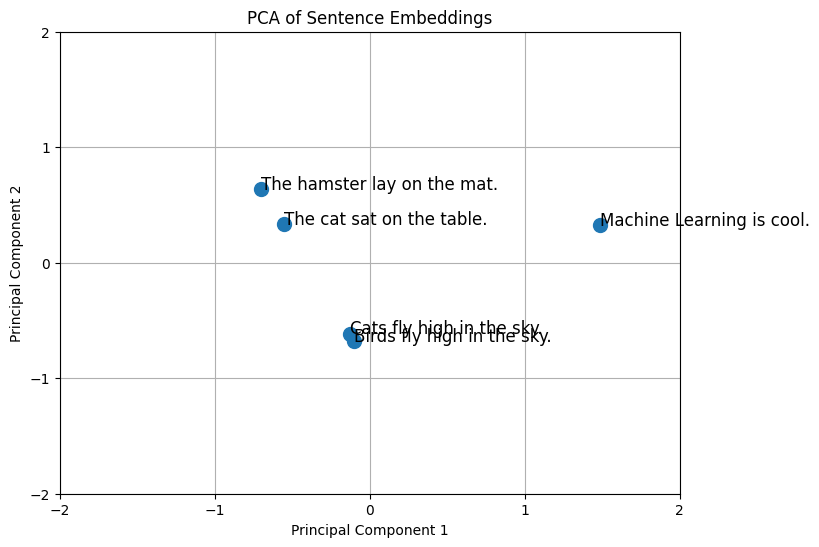

In [16]:
words = [
    "Cat",
    "Dog",
    "Bird",
    "Machine",
    "Car"
]

sentences = [
    "The cat sat on the table.",
    "The hamster lay on the mat.",
    "Birds fly high in the sky.",
    "Cats fly high in the sky.",
    "Machine Learning is cool.",
]

def create_embeddings(inputs: list):
    # Tokenize and encode the sentences
    input_ids = tokenizer(inputs, return_tensors="pt", padding=True, truncation=True)['input_ids'].to(device)
    with no_grad():
        embeddings = model.model.embed_tokens(input_ids)
    print(embeddings.size())
    # Average embeddings across the sequence length in case of sentences
    embeddings = embeddings.mean(dim=1).cpu().numpy()
    # embeddings = embeddings.reshape(-1, embeddings.size()[-1])
    print(embeddings.shape)
    return embeddings

def plot_embeddings(inputs, embeddings):
    # Reduce dimensions to 2D using PCA for visualization
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    # Plot the embeddings
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=100)

    # Annotate points with the sentences
    for i, elem in enumerate(inputs):
        plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], elem, fontsize=12)

    plt.title("PCA of Sentence Embeddings")
    # Set fixed x-axis ticks
    plt.xticks([-2, -1, 0, 1, 2])
    # Set fixed y-axis ticks
    plt.yticks([-2, -1, 0, 1, 2])
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True)
    plt.show()

plot_embeddings(words, create_embeddings(words))

plot_embeddings(sentences, create_embeddings(sentences))

torch.Size([5, 8, 576])
(5, 576)


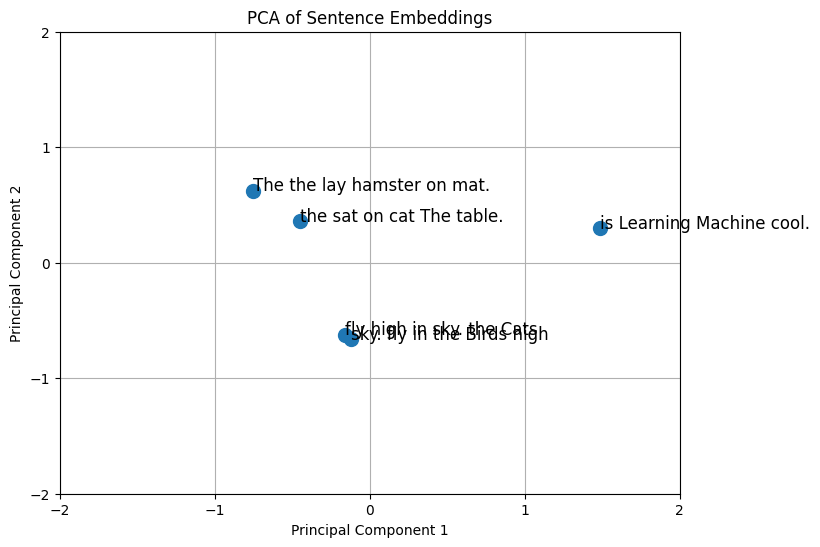

In [17]:
shuffled_sentences = [' '.join(random.sample(sentence.split(), len(sentence.split()))) for sentence in sentences]
plot_embeddings(shuffled_sentences, create_embeddings(shuffled_sentences))

### Positional Encoding

In [18]:
def add_positional_encoding(embeddings):
    """
    Adds positional encoding to token embeddings.

    Parameters:
    token_embeddings (np.ndarray): The token embeddings of shape (seq_len, d_model).
    positional_encodings (np.ndarray): The positional encodings of shape (seq_len, d_model).

    Returns:
    np.ndarray: The embeddings with positional encodings added.
    """
    def positional_encoding(seq_len, d_model):
        """
        Generates positional encoding matrix.

        Parameters:
        seq_len (int): The length of the sequence (number of tokens).
        d_model (int): The dimension of the embeddings.

        Returns:
        np.ndarray: The positional encoding matrix of shape (seq_len, d_model).
        """
        pos = np.arange(seq_len)[:, np.newaxis]
        i = np.arange(d_model)[np.newaxis, :]
        angles = pos / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        angles[:, 0::2] = np.sin(angles[:, 0::2])
        angles[:, 1::2] = np.cos(angles[:, 1::2])
        return angles

    return embeddings * positional_encoding(embeddings.shape[0], embeddings.shape[1])

torch.Size([5, 8, 576])
(5, 576)


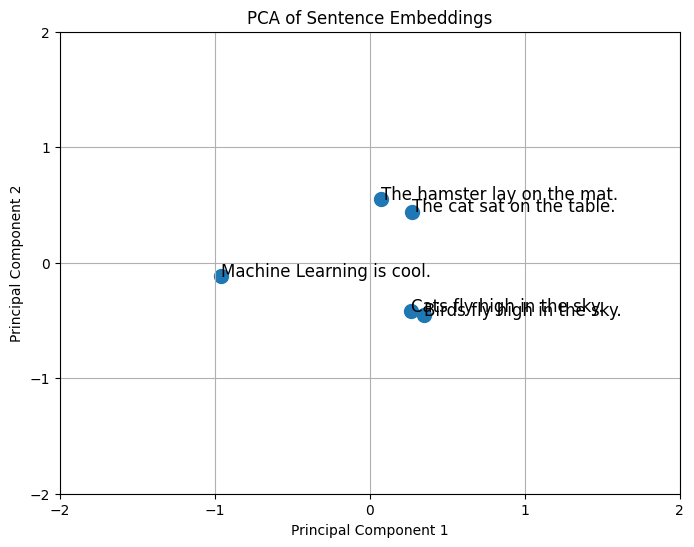

In [19]:
plot_embeddings(sentences, add_positional_encoding(create_embeddings(sentences)))

torch.Size([5, 8, 576])
(5, 576)


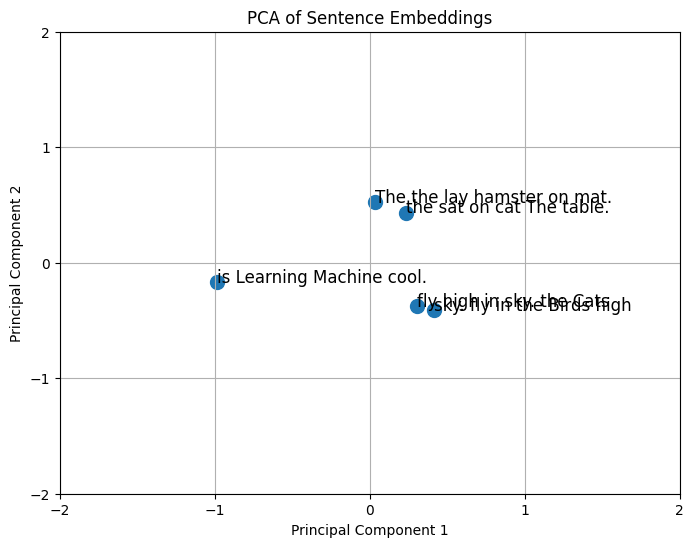

In [20]:
plot_embeddings(shuffled_sentences ,add_positional_encoding(create_embeddings(shuffled_sentences)))

### Attention

In [21]:
def decode_output(output):
    # Assume you have the following logits from your model output with Shape: [1, sequence_length, vocab_size]
    # Step 1: Extract the logits for the last token in the sequence
    last_token_logits = output.logits[:, -1, :]  # Shape: [1, vocab_size]
    # Step 2: Apply softmax to get probabilities
    probs = F.softmax(last_token_logits, dim=-1)  # Shape: [1, vocab_size]
    # Step 3: Get the token with the highest probability
    predicted_token_id = argmax(probs, dim=-1)  # Shape: [1]
    # Convert the token id to a human-readable token (if needed)
    predicted_token = tokenizer.decode(predicted_token_id[0].item())
    print(f"Predicted token id: {predicted_token_id.item()}")
    print(f"Predicted token: {predicted_token}")

# Modify the attention layer to capture attention weights
class AttentionWeightsHook:
    def __init__(self):
        self.attention_weights = []
    
    def __call__(self, module, input, output):
        # print(output[0].shape)
        self.attention_weights.append(output[0])

def get_attention_weights(input_ids):   
    # Create hook and attach it to the attention layers
    hook = AttentionWeightsHook()
    hooks = []

    for layer in model.model.layers:
        hook_handle = layer.self_attn.register_forward_hook(hook)
        hooks.append(hook_handle)

    # Forward pass
    with no_grad():
        output = model(input_ids)
        decode_output(output)

    # Remove hooks after the forward pass
    for handle in hooks:
        handle.remove()

    print(len(hook.attention_weights))
    return hook.attention_weights

In [22]:
def plot_attention_weights(attention_weights, input_ids, layer_idx, head_idx):
    """
    Plot the attention weights of a specific layer and head.

    Parameters:
    - attention_weights: List of attention weights from the hook.
    - layer_idx: Index of the layer to visualize.
    - head_idx: Index of the attention head to visualize.
    """
    # Extract the weights for the specific layer and head
    # Assuming attention_weights is of shape [batch_size, num_heads, seq_len, seq_len]
    
    weights = attention_weights[layer_idx][head_idx]  # Select batch index 0
    #print(weights)
    print(weights.shape)
    att = weights @ weights.T
    print(att.shape)
    tokens = [tokenizer.decode(_id) for _id in input_ids.squeeze()]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(att.numpy(), xticklabels=tokens, yticklabels=tokens)
    plt.title(f'Attention Weights - Layer {layer_idx + 1}, Head {head_idx + 1}')
    plt.xlabel('Token Position')
    plt.ylabel('Token Position')
    plt.show()

Predicted token id: 36
Predicted token: 4
30
torch.Size([7, 576])
torch.Size([7, 7])


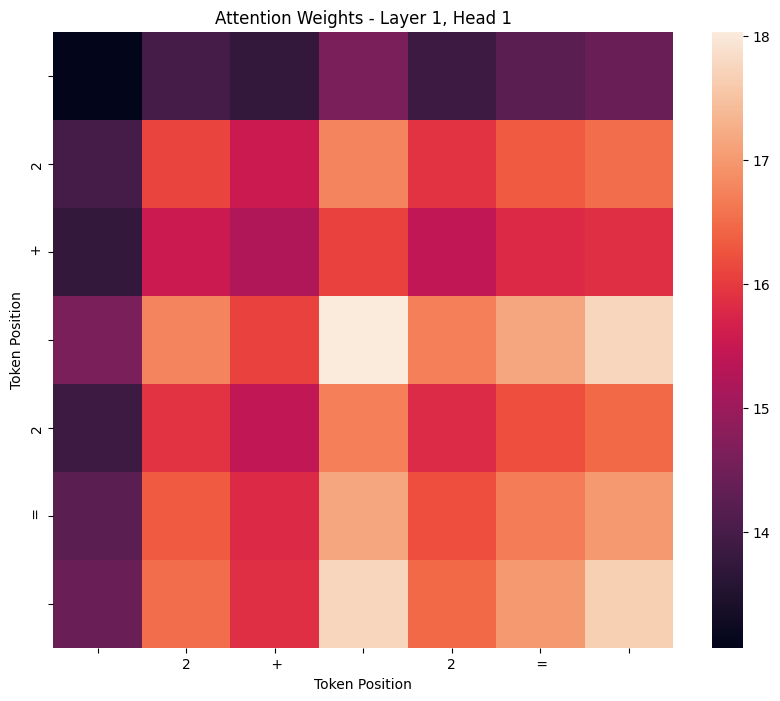

Predicted token id: 36
Predicted token: 4
30
torch.Size([10, 576])
torch.Size([10, 10])


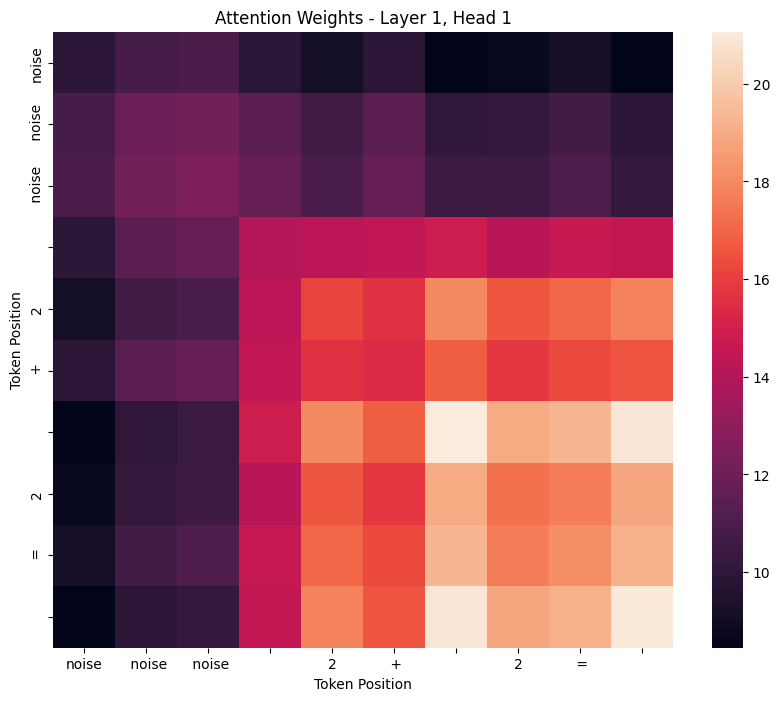

Predicted token id: 33
Predicted token: 1
30
torch.Size([10, 576])
torch.Size([10, 10])


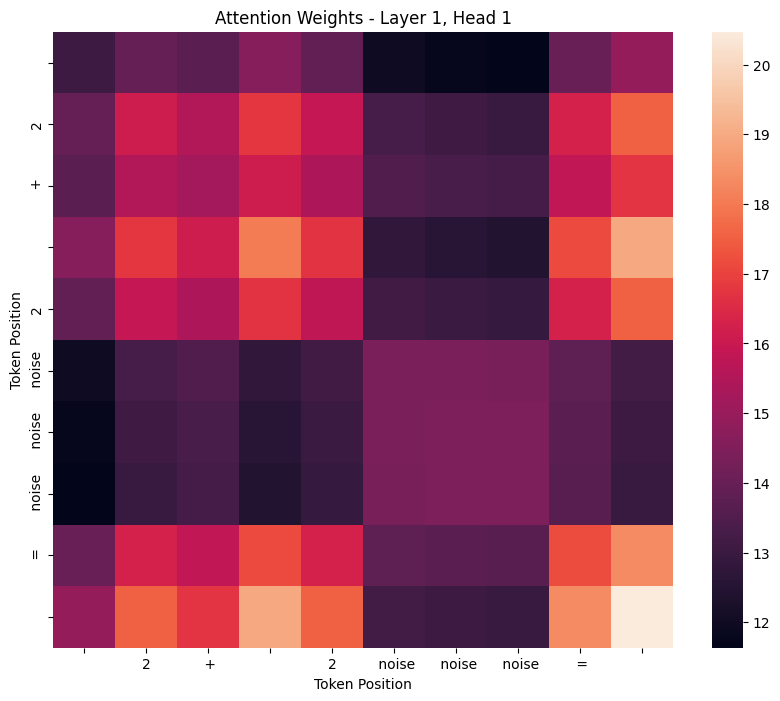

In [25]:
# Example usage
layer_idx = 0  # Index of the layer
head_idx = 0   # Index of the head

# input_sentence = "The cat sat on the table, "
# input_sentence = " 2 + 2 noise noise noise = 4"

input_sentence = " 2 + 2 = "
input_ids = tokenizer.encode(input_sentence, return_tensors="pt")
plot_attention_weights(get_attention_weights(input_ids), input_ids, layer_idx, head_idx)
input_sentence = "noise noise noise 2 + 2 = "
input_ids = tokenizer.encode(input_sentence, return_tensors="pt")
plot_attention_weights(get_attention_weights(input_ids), input_ids, layer_idx, head_idx)
input_sentence = " 2 + 2 noise noise noise = "
input_ids = tokenizer.encode(input_sentence, return_tensors="pt")
plot_attention_weights(get_attention_weights(input_ids), input_ids, layer_idx, head_idx)

In [24]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(49152, 576, padding_idx=2)
    (layers): ModuleList(
      (0-29): 30 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=576, out_features=576, bias=False)
          (k_proj): Linear(in_features=576, out_features=192, bias=False)
          (v_proj): Linear(in_features=576, out_features=192, bias=False)
          (o_proj): Linear(in_features=576, out_features=576, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=576, out_features=1536, bias=False)
          (up_proj): Linear(in_features=576, out_features=1536, bias=False)
          (down_proj): Linear(in_features=1536, out_features=576, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((576,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((576,), eps=1e-05)
      )
    )
    (norm

### Next Token Prediction

In [ ]:
# TODO: decide if that is useful